In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import itertools
from ipywidgets import interact
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
class FormulaFeatureGenerator():
    def __init__(self, exponents: list = [-1, -.5, 0, 1, 2]):
        self.exponents = exponents
        self.small_number = 1e-20
    
    def fit(self, x: np.array):
        self.var_list = np.arange(x.shape[1])
        var_exps_lists = [[(v, e) for e in self.exponents]
                          for v in self.var_list]
        self.combinations = list(itertools.product(*var_exps_lists))
    
    def get_feature_names(self):
        assert hasattr(self, 'combinations'), 'call fit method first'
        feature_names = ['*'.join([f'x_{c[i][0]}^({c[i][1]})'
                                   if c[i][1] != 0 else '1'
                                   for i in self.var_list])
                        for c in self.combinations]
        return feature_names
    
    def _create_single_feature(self, x: np.array, tup: tuple):
        x[x == 0] = self.small_number
        return [np.prod([np.real(float(x[i, j])**ei) for j, ei in tup])
                for i in range(x.shape[0])]

    def transform(self, x: np.array):
        x_new = np.zeros((x.shape[0], len(self.combinations)))
        for i, tup in enumerate(self.combinations):
            x_new[:, i] = self._create_single_feature(x, tup)
        return x_new
    
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

In [8]:
def plot_function(X, z):
    fig = px.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], color=z)
    fig.update_layout(height=500, width=500,
                      title='Function vizualization')
    fig.show()
    
def transform_data(X, exponents, scaler=StandardScaler()):
    """"""
    ffg = FormulaFeatureGenerator(exponents=exponents)
    X_ = ffg.fit_transform(X)
    X__ = scaler.fit_transform(X_)
    return X__, ffg, scaler

def fit_model(X__, z, alpha=1):
    model = linear_model.Lasso(alpha=alpha, max_iter=10000)
    model.fit(X__, z)
    return model

def get_terms(model, ffg):
    non_zero_idx = np.where(model.coef_ != 0)
    df_results = pd.DataFrame(dict(names=[ffg.get_feature_names()[i]
                                          for i in non_zero_idx[0]],
         coefs=[model.coef_[i] for i in non_zero_idx[0]]))
    return df_results

In [9]:
x0 = np.random.uniform(-1, 1, 10000)
x1 = np.random.uniform(-1, 1, 10000)
x2 = np.random.uniform(-1, 1, 10000)
X = np.column_stack((x0, x1, x2))

def run(function, exponents, alpha, fit, plot_func):
    if fit:
        z = eval(function)
        X__, ffg, _ = transform_data(X, eval(exponents))
        model = fit_model(X__, z, alpha=alpha)
        res_df = get_terms(model, ffg)
        print('Result: \n')
        print(res_df.to_markdown())
        if plot_func:
            plot_function(X, z)

interact(run, function='x0', exponents='[-1, -.5, 0, 1, 2]',
         alpha=[.01, .1, .5, .75, 1, 1.5, 2, 3], fit=False, plot_func=False)



interactive(children=(Text(value='x0', description='function'), Text(value='[-1, -.5, 0, 1, 2]', description='…

<function __main__.run(function, exponents, alpha, fit, plot_func)>

In [7]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [ ]:
x0 = np.random.uniform(-1, 1, 10000)
x1 = np.random.uniform(-1, 1, 10000)
x2 = np.random.uniform(-1, 1, 10000)
X = np.column_stack((x0, x1, x2))
z = np.array([np.real(float(x)**(-.5)) for x in x0])
# X__, ffg, _ = transform_data(X, [-1, -.5, 0, 1])
# model = fit_model(X__, z, alpha=.1)
# res_df = get_terms(model, ffg)
# print('Result: \n')
# print(res_df.to_markdown()) 

In [28]:
from src.model.formula_features import FormulaFeatureGenerator as FormulaFeatureGenerator2

In [47]:
np.random.randint(1, 10, 3)

array([2, 7, 3])

In [48]:
x = np.random.(1, 10, 16).reshape(-1, 4)
ffg = FormulaFeatureGenerator2(exponents=[1])
ffg.fit(x)
x_trans = ffg.transform(x)

/home/henrik/Documents/diss/mario-communicating-agents/src/model/formula_features.py:37: RuntimeWarning: divide by zero encountered in true_divide
  return 1 / (x[:, tup[0]] - x[:, tup[1]])


In [49]:
ffg.get_data_frame(x_trans)

,x_0^(1)*x_1^(1)*x_2^(1)*x_3^(1),1/(x_0 - x_1),1/(x_0 - x_2),1/(x_0 - x_3),1/(x_1 - x_2),1/(x_1 - x_3),1/(x_2 - x_3),1/(x_1 - x_0),1/(x_2 - x_0),1/(x_3 - x_0),1/(x_2 - x_1),1/(x_3 - x_1),1/(x_3 - x_2)
0,120.0,1.00,0.333333,0.500000,0.500000,1.000000,-1.000000,-1.00,-0.333333,-0.500000,-0.500000,-1.000000,1.000000
1,50.0,0.25,inf,0.333333,-0.250000,-1.000000,0.333333,-0.25,inf,-0.333333,0.250000,1.000000,-0.333333
2,972.0,1.00,-0.200000,-0.200000,-0.166667,-0.166667,inf,-1.00,0.200000,0.200000,0.166667,0.166667,inf
3,512.0,-0.25,0.500000,-0.250000,0.166667,inf,-0.166667,0.25,-0.500000,0.250000,-0.166667,inf,0.166667


In [50]:
x

array([[5, 4, 2, 3],
       [5, 1, 5, 2],
       [4, 3, 9, 9],
       [4, 8, 2, 8]])

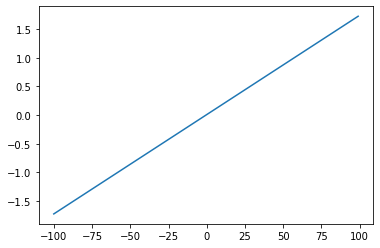

In [25]:
x = np.arange(-100, 100)
y = (x - x.mean()) / x.std()
import matplotlib.pyplot as plt
plt.plot(x,y)

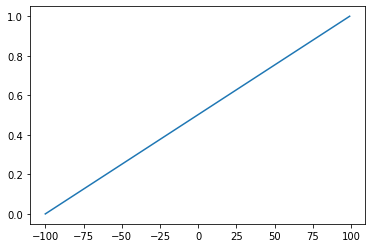

In [26]:
x = np.arange(-100, 100)
y = (x - x.min()) / (x.max() - x.min())
import matplotlib.pyplot as plt
plt.plot(x,y)